In [1]:
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import scipy
import nltk
import os
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.cross_validation import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold


stop_words = set(stopwords.words('english')) 
stop_words= list(stop_words)+['per','existing','plan']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
#data=pd.read_csv()
# data = pd.read_csv('/content/drive/My Drive/train_file.csv')
# data_test = pd.read_csv('/content/drive/My Drive/test_file.csv')
path = "C:\\Users\\Admin\\Desktop\\New_folder"
data_folder = "\\dataset"
os.chdir(path+data_folder)
data = pd.read_csv(path+data_folder+'\\train_file.csv')
data_test =pd.read_csv(path+data_folder+'\\test_file.csv')
#!ls "/content/drive/My Drive"

In [22]:
data.isnull().sum() #checking the null values in train dataset
data = data.dropna(subset=['Permit Type','Action Type','Work Type','Latitude','Longitude','Status','Description'])


Since most of the feature variables are categorical, We will apply chi-square test to assess the dependence between the features and the output variables

In [23]:

x1=scipy.stats.chisquare(data['Permit Type'].value_counts())
y=scipy.stats.chisquare(data['Category'].value_counts())
cont= pd.crosstab(data['Permit Type'],data['Category'])
stat, p, dof, expected =scipy.stats.chi2_contingency(cont)
if p <= 0.05:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

x2=scipy.stats.chisquare(data['Action Type'].value_counts())
y=scipy.stats.chisquare(data['Category'].value_counts())
cont= pd.crosstab(data['Action Type'],data['Category'])
stat, p, dof, expected =scipy.stats.chi2_contingency(cont)
if p <= 0.05:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
#%%
x3=scipy.stats.chisquare(data['Work Type'].value_counts())
y=scipy.stats.chisquare(data['Category'].value_counts())
cont= pd.crosstab(data['Work Type'],data['Category'])
stat, p, dof, expected =scipy.stats.chi2_contingency(cont)
if p <= 0.05:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
#%%
x4=scipy.stats.chisquare(data['Status'].value_counts())
y=scipy.stats.chisquare(data['Category'].value_counts())
cont= pd.crosstab(data['Status'],data['Category'])
stat, p, dof, expected =scipy.stats.chi2_contingency(cont)
if p <= 0.05:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
#%%
x5=scipy.stats.chisquare(data['Contractor'].value_counts())
y=scipy.stats.chisquare(data['Category'].value_counts())
cont= pd.crosstab(data['Contractor'],data['Category'])
stat, p, dof, expected =scipy.stats.chi2_contingency(cont)
if p <= 0.05:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Dependent (reject H0)
Dependent (reject H0)
Dependent (reject H0)
Dependent (reject H0)
Dependent (reject H0)


In [24]:
# We saw that the columns - 'Permit Type', 'Action Type','Work Type','Status' are important. We can convert them to numeric using get_dummies function in pandas. 
df=pd.get_dummies(data, columns= ['Permit Type', 'Action Type','Work Type','Status'])
data['Master Use Permit2']=data['Master Use Permit']
data['Master Use Permit2'].fillna(0, inplace=True)
data.loc[data['Master Use Permit2'] != 0, 'Master Use Permit2'] = 1
df['Master Use Permit']= data['Master Use Permit2']
df.drop(['Application Date','Issue Date','Final Date','Expiration Date','Application/Permit Number',
      'Address','Applicant Name','Permit and Complaint Status URL','Location','Contractor','Description'],axis=1, inplace=True)
#on test
df_test= pd.get_dummies(data_test, columns= ['Permit Type', 'Action Type','Work Type','Status'])
data_test['Master Use Permit2']=data_test['Master Use Permit']
data_test['Master Use Permit2'].fillna(0, inplace=True)
data_test.loc[data_test['Master Use Permit2'] != 0, 'Master Use Permit2'] = 1
df_test['Master Use Permit']= data_test['Master Use Permit2']
df_test.drop(['Application Date','Issue Date','Final Date','Expiration Date','Application/Permit Number',
      'Address','Applicant Name','Permit and Complaint Status URL','Location','Contractor','Description'],axis=1, inplace=True)

#We dropeed the unnecessary columns from both train and test. 

In [25]:
print (df.shape)
print (df_test.shape)
#Becasue we can't drop the columns in test, we impute them using their corresponding means. 
df_test['Latitude'].fillna(value= np.mean(df_test['Latitude']), inplace=True)
df_test['Longitude'].fillna(value= np.mean(df_test['Longitude']),inplace=True)


(31551, 36)
(22360, 35)


In [26]:
#checking the null values in test dataset .
df_test.isnull().sum()

Master Use Permit                            0
Latitude                                     0
Longitude                                    0
Permit Type_Construction                     0
Permit Type_Demolition                       0
Permit Type_Site Development                 0
Action Type_ADD/ALT                          0
Action Type_ALTER                            0
Action Type_CURB CUT                         0
Action Type_DECONSTRUCTION                   0
Action Type_DEMOLITION                       0
Action Type_DRAINAGE APPROVAL                0
Action Type_GRADING                          0
Action Type_NEW                              0
Action Type_NO CONSTRUCTION                  0
Action Type_RELOCATION                       0
Action Type_SHORELINE EXEMPTION ONLY         0
Action Type_SITE MONITORING ONLY             0
Action Type_TEMP                             0
Action Type_TREE PROTECTION EXEMPTION        0
Action Type_TREE/VEGETATION MAINT/RESTORE    0
Work Type_No 

In few of the below block of codes, I have tried including the 'Description' column for prediction. I have used HashingVectorizer to extract useful features from that text and have build some basic models with them. I have reoeated the same procedure excluding the 'Description' column. The results are slightly better for the latter method. Hence it was decided to drop off the 'Description' feature for the final model building. 
These blocks have **Code including** '**Description**'  headline on them for reference. 


In [7]:
#Code including 'Description'
#In order to extract useful information from 'description' column, we are using HashingVectorizer to convert the text into useful vectors. 
#One of the adv of hashing method has is we can control the number of features we want at the end. I have kept it as 10. 
#Which I will further reduce by applying PCA. 
#from sklearn.feature_extraction.text import HashingVectorizer
#text = data['Description']
#text_test= data_test['Description']
#text_test.fillna('No Description Available', inplace=True)
##total_test= text.append(text_test, ignore_index= True)
#
#vectorizer = HashingVectorizer(n_features=10,strip_accents = 'unicode',decode_error ='ignore'
#                ,analyzer='word',stop_words=stop_words, token_pattern=r'\w+', norm='l1', ngram_range=(2,3),
#                 tokenizer= nltk.tokenize.word_tokenize)
## encode document
#vector = vectorizer.transform(text)
#vector_test = vectorizer.transform(text_test)
#
## summarize encoded vector
#print(vector.shape)
#vector_ar= vector.toarray()
#vector_ar= np.array(vector_ar)
#vector_test_ar= vector_test.toarray()
#vector_test_ar= np.array(vector_test_ar)


(31551, 10)


In [0]:
##Code including 'Description'
#from sklearn.decomposition import PCA
#pca = PCA().fit(vector_ar)
#import matplotlib.pyplot as plt
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
#plt.grid(True)
#plt.show()


In [0]:
#Code including 'Description'
#Taking 6 component we can capture ~ 75% of the variance
#pca = PCA(n_components=6)
#pca.fit(vector_ar)
#train_text_pca= pca.transform(vector_ar)
#test_text_pca= pca.transform(vector_test_ar)


In [0]:
#Code including 'Description'
#print (train_text_pca.shape)
#print (test_text_pca.shape)

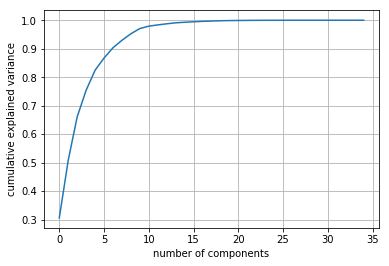

In [27]:
#There are total 35 feature vectors in the train dataset and most of them are sparse. Hence we can apply PCA on 
#these features separately to get the features which catch maximum variance. 
from sklearn.decomposition import PCA
df_x=df.drop(['Category'],axis=1)
df_y= df['Category']
df_ar_x= np.array(df_x)
pca_2 = PCA().fit(df_ar_x)
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.show()


In [28]:
#Total of 10 features will give us more than 90% variance. 
pca_2 = PCA(n_components=10)
pca_2.fit(df_ar_x)
df_x_pca= pca_2.transform(df_ar_x)
df_test_pca= pca_2.transform(df_test)

In [29]:
y = df_y.map({'SINGLE FAMILY / DUPLEX':1,
'COMMERCIAL':2,
'INSTITUTIONAL':3,
'MULTIFAMILY':4,
'INDUSTRIAL':5})



In [0]:
#Code including 'Description'
#print (df_x_pca.shape)
#print (train_text_pca.shape)

In [0]:
#Code including 'Description'
#Concatenating the features we got from 'Description' column and the rest of the columns
#x=np.concatenate((df_x_pca, train_text_pca), axis=1)
#x_test_set= np.concatenate((df_test_pca, test_text_pca), axis=1)

In [0]:
#Code including 'Description'
#X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size= 0.1)
##Let us apply some basic algorithms with default hyperparameters and check their performance. 
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from sklearn.neural_network import MLPClassifier
#
#models_text = []
#models.append(('Logistic Regression', LogisticRegression()))
#models.append(('Naive Bayes', GaussianNB()))
#models.append(('Decision Tree (CART)',DecisionTreeClassifier())) 
#models.append(('K-NN', KNeighborsClassifier()))
#models.append(('AdaBoostClassifier', AdaBoostClassifier()))
#models.append(('RandomForestClassifier', RandomForestClassifier()))
#models.append(('XGBClassifier', XGBClassifier()))
#
#
#f1_text={}
#for name, model in models:
#    model = model.fit(X_train, Y_train)
#    y_pred = model.predict(X_test)
#    score=f1_score(Y_test,y_pred, average='weighted')
#    f1_text[name]= score

In [0]:
#Code including 'Description'
#print (f1_text)

In [30]:
# Splitting train-test dataset. Ratio is kept at 90-10. 
X_train, X_test, Y_train, Y_test = train_test_split(df_x_pca,y, test_size= 0.1)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(28395, 10)
(3156, 10)
(28395,)
(3156,)


In [31]:
#Let us apply some basic algorithms with default hyperparameters and check their performance. 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Decision Tree (CART)',DecisionTreeClassifier())) 
models.append(('K-NN', KNeighborsClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('XGBClassifier', XGBClassifier()))


f1={}
for name, model in models:
    model = model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    score=f1_score(Y_test,y_pred, average='weighted')
    f1[name]= score

C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precis

In [19]:
print (f1)

{'Logistic Regression': 0.5391194304075346, 'Naive Bayes': 0.5187992490960537, 'Decision Tree (CART)': 0.7459757818194588, 'K-NN': 0.7360183232501272, 'AdaBoostClassifier': 0.5935296355191797, 'RandomForestClassifier': 0.7740585196239315, 'XGBClassifier': 0.6483495064424986}


We can see that the results are slightly better when we exclude the features obtained from 'Description' column. 
Hence we will go ahead with those features only .

We will choose random forrest and xgboost for further tuning and final prediction. 

In [21]:
ran_for = RandomForestClassifier(n_estimators= 1000, verbose=1, max_features= 7)
ran_for = ran_for.fit(X_train, Y_train)

    # predict
ran_for_pred = ran_for.predict(X_test)
    
    # score
ran_for_score = f1_score(Y_test, ran_for_pred, average='weighted')
#ran_for_score= 0.7785164815102673 for 500 estimators and 8 max features
#ran_for_score= 0.7886976094393479 for 1000 estimators and 7 max features

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.1s finished


In [22]:
ran_for_score

0.7861663672574308

In [23]:
xgb = XGBClassifier(n_estimators=5000,min_child_weight= 1, learning_rate=0.12, objective='multi:softmax', max_depth =6,silent=True, nthread=1, n_jobs=-1)
xgb.fit(X_train, Y_train,eval_metric= 'merror')
pred= xgb.predict(X_test)
f1_score(pred, Y_test, average='weighted')
#0.7999791841749769



C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.791816279716481

In [24]:
#Another instance of XgBoost classifier with tweaked hyperparameters. 
xgb2 = XGBClassifier(n_estimators=10000,min_child_weight= 1, learning_rate=0.12, objective='multi:softmax', max_depth =6,silent=True, nthread=1,verbose=4)
xgb2.fit(X_train, Y_train,eval_metric= 'merror')
pred= xgb2.predict(X_test)
f1_score(pred, Y_test, average='weighted')


C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7884846150751172

In [25]:
#Another instance of XgBoost classifier with tweaked hyperparameters. 
xgb3 = XGBClassifier(n_estimators=5000,min_child_weight= 1, learning_rate=0.5, objective='multi:softmax', max_depth =6,silent=True, nthread=1)
xgb3.fit(X_train, Y_train,eval_metric= 'merror')
pred= xgb3.predict(X_test)
f1_score(pred, Y_test, average='weighted')


C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7897979132733284

In [26]:
xgb4 = XGBClassifier(n_estimators=5000,min_child_weight= 1, learning_rate=0.5, objective='multi:softmax', max_depth =8,silent=True, nthread=1)
xgb4.fit(X_train, Y_train,eval_metric= 'merror')
pred= xgb4.predict(X_test)
f1_score(pred, Y_test, average='weighted')



C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7890774540216932

In [27]:
unseen_pred_xgb1= xgb.predict(df_test_pca)
unseen_pred_rf= ran_for.predict(df_test_pca)
unseen_pred_xgb3=xgb3.predict(df_test_pca)

C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
C:\Users\Admin\Anaconda2\envs\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
unseen_pred_df= pd.Series(unseen_pred_xgb1)
unseen_pred_df = unseen_pred_df.map({1:'SINGLE FAMILY / DUPLEX',
2:'COMMERCIAL',
3:'INSTITUTIONAL',
4:'MULTIFAMILY',
5:'INDUSTRIAL'})
unseen_pred_rf_df= pd.Series(unseen_pred_rf)
unseen_pred_rf_df = unseen_pred_rf_df.map({1:'SINGLE FAMILY / DUPLEX',
2:'COMMERCIAL',
3:'INSTITUTIONAL',
4:'MULTIFAMILY',
5:'INDUSTRIAL'})
unseen_pred_xgb3_df= pd.Series(unseen_pred_xgb3)
unseen_pred_xgb3_df = unseen_pred_xgb3_df.map({1:'SINGLE FAMILY / DUPLEX',
2:'COMMERCIAL',
3:'INSTITUTIONAL',
4:'MULTIFAMILY',
5:'INDUSTRIAL'})


These 3 results qualify as the best results as of now.

### Thank you!